### Import bnlearn library, which is a wrapper on pytorch that's specifically designed for bayesian networks. and other important tools


In [1]:
# load cleaned dataset and train a model
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import bnlearn as bn

### Load dataset


In [2]:
# load cleaned dataset
data = pd.read_csv("Real_Estate_Sales_2001-2022_GL_20240919_cleaned.csv")

data.head()

,List Year,Date Recorded,Town,Property Type,Residential Type,Sale Amount Category,Assessed Value Category
0,2022,2023,Andover,Residential,Single Family,200k,100k
1,2020,2021,Ansonia,Commercial,Empty,200k,100k
2,2020,2020,Ashford,Residential,Single Family,200k,200k
3,2021,2022,Avon,Residential,Single Family,500ks,200k
4,2020,2021,Avon,Residential,Condo,100k,100k


### Encode our dataset for bnlearn.


In [3]:
dfhot, dfnum = bn.df2onehot(data)

[Warning]> This release requires scikit-learn version >= 1.4.0. Try: pip install -U scikit-learn

[df2onehot] >Auto detecting dtypes.


  0%|          | 0/7 [00:00<?, ?it/s]

100%|██████████| 7/7 [00:04<00:00,  1.73it/s]


[df2onehot] >Set dtypes in dataframe..


[df2onehot]: 100%|██████████| 7/7 [00:01<00:00,  6.70it/s]

[df2onehot] >Total onehot features: 185


### dfhot includes the encoded variables as columns


In [9]:
# display real and mapped categories for each variable
dfhot.head()

,List Year_2020.0,List Year_2021.0,List Year_2022.0,Date Recorded_2020.0,Date Recorded_2021.0,Date Recorded_2022.0,Date Recorded_2023.0,Town_Andover,Town_Ansonia,Town_Ashford,...,Sale Amount Category_1k,Sale Amount Category_1m,Sale Amount Category_2k,Sale Amount Category_500ks,Sale Amount Category_Upto 100k,Assessed Value Category_1k,Assessed Value Category_1m,Assessed Value Category_2k,Assessed Value Category_500ks,Assessed Value Category_Upto 100k
0,False,False,True,False,False,False,True,True,False,False,...,False,False,True,False,False,True,False,False,False,False
1,True,False,False,False,True,False,False,False,True,False,...,False,False,True,False,False,True,False,False,False,False
2,True,False,False,True,False,False,False,False,False,True,...,False,False,True,False,False,False,False,True,False,False
3,False,True,False,False,False,True,False,False,False,False,...,False,False,False,True,False,False,False,True,False,False
4,True,False,False,False,True,False,False,False,False,False,...,True,False,False,False,False,True,False,False,False,False


### This one contains the original dataset with numerical categorizations


In [10]:
dfnum.head()

,List Year,Date Recorded,Town,Property Type,Residential Type,Sale Amount Category,Assessed Value Category
0,3,4,1,4,4,3,1
1,1,2,2,2,2,3,1
2,1,1,3,4,4,3,3
3,2,3,4,4,4,4,3
4,1,2,4,4,1,1,1


### inorder to understand later which numerical category belongs to which variable, let's construct a dictionary of all nodes and their possible values, with their numerical category


In [15]:
# loop through dfhot columns
valuesDict = {}
variablesDict = {}
for col in dfhot.columns:
    varName, varValue = col.split("_")
    numCategory = 1
    if varName in variablesDict:
        numCategory = variablesDict[varName] + 1
    variablesDict[varName] = numCategory
    if varName in valuesDict:
        newDict = valuesDict[varName]
        newDict[varValue] = numCategory
        valuesDict[varName] = newDict
    else:
        valuesDict[varName] = {}
        valuesDict[varName][varValue] = numCategory

# pretty print the valuesDict
for key in valuesDict:
    print(key)
    print(valuesDict[key], "\n")

List Year
{'2020.0': 1, '2021.0': 2, '2022.0': 3} 

Date Recorded
{'2020.0': 1, '2021.0': 2, '2022.0': 3, '2023.0': 4} 

Town
{'Andover': 1, 'Ansonia': 2, 'Ashford': 3, 'Avon': 4, 'Barkhamsted': 5, 'Beacon Falls': 6, 'Berlin': 7, 'Bethany': 8, 'Bethel': 9, 'Bethlehem': 10, 'Bloomfield': 11, 'Bolton': 12, 'Bozrah': 13, 'Branford': 14, 'Bridgeport': 15, 'Bridgewater': 16, 'Bristol': 17, 'Brookfield': 18, 'Brooklyn': 19, 'Burlington': 20, 'Canaan': 21, 'Canterbury': 22, 'Canton': 23, 'Chaplin': 24, 'Cheshire': 25, 'Chester': 26, 'Clinton': 27, 'Colchester': 28, 'Colebrook': 29, 'Columbia': 30, 'Cornwall': 31, 'Coventry': 32, 'Cromwell': 33, 'Danbury': 34, 'Darien': 35, 'Deep River': 36, 'Derby': 37, 'Durham': 38, 'East Granby': 39, 'East Haddam': 40, 'East Hampton': 41, 'East Hartford': 42, 'East Haven': 43, 'East Lyme': 44, 'East Windsor': 45, 'Eastford': 46, 'Easton': 47, 'Ellington': 48, 'Enfield': 49, 'Essex': 50, 'Fairfield': 51, 'Farmington': 52, 'Franklin': 53, 'Glastonbury': 54, '

# Structure learning of our network from the data, it by default uses hill climb search with a bic scoring


In [16]:
# Structure learning

# set permanent edge Residential Type => Assessed Value Category
DAG = bn.structure_learning.fit(
    dfnum,
    fixed_edges=[
        ("Assessed Value Category", "Sale Amount Category"),
    ],
)

# Plot
G = bn.plot(DAG, interactive=True)

[bnlearn] >Computing best DAG using [hc]
[bnlearn] >Set scoring type at [bic]
[bnlearn] >Compute structure scores for model comparison (higher is better).
[bnlearn] >Set node properties.
[bnlearn] >Set edge properties.


[d3blocks] >INFO> Cleaning edge_properties and config parameters..
[d3blocks] >INFO> Converting source-target into adjacency matrix..
[d3blocks] >INFO> Making the matrix symmetric..
[d3blocks] >INFO> Set directed=True to see the markers!
[d3blocks] >INFO> Keep only edges with weight>0
[d3blocks] >INFO> Converting source-target into adjacency matrix..
[d3blocks] >INFO> Making the matrix symmetric..
[d3blocks] >INFO> Converting adjacency matrix into source-target..
[d3blocks] >INFO> Number of unique nodes: 7
[d3blocks] >INFO> Slider range is set to [0, 1]
[d3blocks] >INFO> Write to path: [C:\Users\yared\AppData\Local\Temp\tmpt9b_p_1g\d3graph.html]
[d3blocks] >INFO> File already exists and will be overwritten: [C:\Users\yared\AppData\Local\Temp\tmpt9b_p_1g\d3graph.html]
[d3blocks] >INFO> Keep only edges with weight>0
[d3blocks] >INFO> Converting source-target into adjacency matrix..
[d3blocks] >INFO> Making the matrix symmetric..
[d3blocks] >INFO> Number of unique nodes: 7
[d3blocks] >INF

# Our constructed DAG structure (screenshot from interactive session)


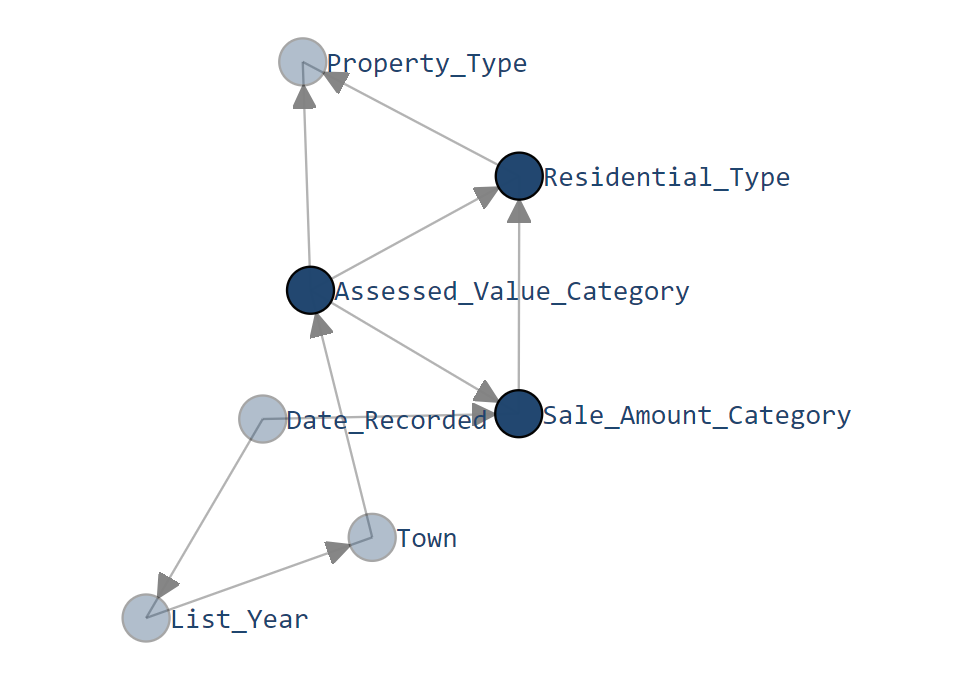


# Parameter learning, it by default uses bayesian estimation


In [17]:
# Parameter learning
model = bn.parameter_learning.fit(DAG, dfnum)

[bnlearn] >Parameter learning> Computing parameters using [bayes]
[bnlearn] >Converting [<class 'pgmpy.base.DAG.DAG'>] to BayesianNetwork model.
[bnlearn] >Converting adjmat to BayesianNetwork.
[bnlearn] >CPD of List Year:
+--------------+----------+
| List Year(1) | 0.664804 |
+--------------+----------+
| List Year(2) | 0.213322 |
+--------------+----------+
| List Year(3) | 0.121874 |
+--------------+----------+
[bnlearn] >CPD of Date Recorded:
+------------------+-----+----------------------+
| List Year        | ... | List Year(3)         |
+------------------+-----+----------------------+
| Date Recorded(1) | ... | 0.006860781031312604 |
+------------------+-----+----------------------+
| Date Recorded(2) | ... | 0.006860781031312604 |
+------------------+-----+----------------------+
| Date Recorded(3) | ... | 0.2671862564834381   |
+------------------+-----+----------------------+
| Date Recorded(4) | ... | 0.7190921814539367   |
+------------------+-----+----------------------

In [18]:
# print cpds
bn.print_CPD(model)

[bnlearn] >Warning: variable(s) [None] does not exists in DAG.
[bnlearn] >Data is stored in [query.df]
+----+-------------+----------+
|    |   List Year |        p |
+====+=============+==========+
|  0 |           1 | 0.664804 |
+----+-------------+----------+
|  1 |           2 | 0.213322 |
+----+-------------+----------+
|  2 |           3 | 0.121874 |
+----+-------------+----------+
CPD of List Year:
+--------------+----------+
| List Year(1) | 0.664804 |
+--------------+----------+
| List Year(2) | 0.213322 |
+--------------+----------+
| List Year(3) | 0.121874 |
+--------------+----------+
[bnlearn] >Warning: variable(s) [None] does not exists in DAG.
[bnlearn] >Data is stored in [query.df]
+----+-----------------+-------------+------------+
|    |   Date Recorded |   List Year |          p |
+====+=================+=============+============+
|  0 |               1 |           1 | 0.273081   |
+----+-----------------+-------------+------------+
|  1 |               1 |        

{'List Year':    List Year         p
 0          1  0.664804
 1          2  0.213322
 2          3  0.121874,
 'Date Recorded':     Date Recorded  List Year         p
 0               1          1  0.273081
 1               1          2  0.003920
 2               1          3  0.006861
 3               2          1  0.724404
 4               2          2  0.279644
 5               2          3  0.006861
 6               3          1  0.001258
 7               3          2  0.712516
 8               3          3  0.267186
 9               4          1  0.001258
 10              4          2  0.003920
 11              4          3  0.719092,
 'Town':      Town  List Year         p
 0       0          1  0.000062
 1       0          2  0.000240
 2       0          3  0.000174
 3       1          1  0.001058
 4       1          2  0.000099
 ..    ...        ...       ...
 469   156          2  0.000146
 470   156          3  0.000256
 471   157          1  0.003277
 472   157          2  0

# 🌟INFERENCE


# Reference tab


In [54]:
# print values for reference first
for key in valuesDict:
    print(key)
    print(valuesDict[key], "\n")

List Year
{'2020.0': 1, '2021.0': 2, '2022.0': 3} 

Date Recorded
{'2020.0': 1, '2021.0': 2, '2022.0': 3, '2023.0': 4} 

Town
{'Andover': 1, 'Ansonia': 2, 'Ashford': 3, 'Avon': 4, 'Barkhamsted': 5, 'Beacon Falls': 6, 'Berlin': 7, 'Bethany': 8, 'Bethel': 9, 'Bethlehem': 10, 'Bloomfield': 11, 'Bolton': 12, 'Bozrah': 13, 'Branford': 14, 'Bridgeport': 15, 'Bridgewater': 16, 'Bristol': 17, 'Brookfield': 18, 'Brooklyn': 19, 'Burlington': 20, 'Canaan': 21, 'Canterbury': 22, 'Canton': 23, 'Chaplin': 24, 'Cheshire': 25, 'Chester': 26, 'Clinton': 27, 'Colchester': 28, 'Colebrook': 29, 'Columbia': 30, 'Cornwall': 31, 'Coventry': 32, 'Cromwell': 33, 'Danbury': 34, 'Darien': 35, 'Deep River': 36, 'Derby': 37, 'Durham': 38, 'East Granby': 39, 'East Haddam': 40, 'East Hampton': 41, 'East Hartford': 42, 'East Haven': 43, 'East Lyme': 44, 'East Windsor': 45, 'Eastford': 46, 'Easton': 47, 'Ellington': 48, 'Enfield': 49, 'Essex': 50, 'Fairfield': 51, 'Farmington': 52, 'Franklin': 53, 'Glastonbury': 54, '

### function description: Accepts model, queried variables, and evidence variables, makes inference and pretty prints as best it can

### the printed assessment is sorted in descending order of the final probabilities


In [50]:
# make function for inference.
def infer(model, variables, evidence):
    q1 = bn.inference.fit(model, variables=variables, evidence=evidence, verbose=0)
    columns = list(q1.df.columns)
    # change sale amount category to real categories
    for index, row in q1.df.iterrows():
        # get columns without p
        cols = [col for col in columns if col != "p"]
        for col in cols:
            num_cat = q1.df.at[index, col]
            # find which key has num_cat value
            for key in valuesDict[col]:
                if num_cat == valuesDict[col][key]:
                    break

            q1.df.at[index, col] = key
    print("Evidence Values", "\n----------")
    for key in evidence.keys():
        num_cat = evidence[key]
        for val_key in valuesDict[key]:
            if num_cat == valuesDict[key][val_key]:
                break
        print(f"{key} => {val_key}")
    print("--------")
    # sort descending with p
    q1.df = q1.df.sort_values(by="p", ascending=False)
    print(q1.df)

In [76]:
print("given assessed = 100k, and town = Andover, what is the probability of sale")
evidence = {
    "Assessed Value Category": valuesDict["Assessed Value Category"]["1k"],
    "Town": valuesDict["Town"]["Andover"],
}
variables = ["Sale Amount Category"]

infer(model, variables, evidence)

given assessed = 100k, and town = Andover, what is the probability of sale
Evidence Values 
----------
Assessed Value Category => 1k
Town => Andover
--------
  Sale Amount Category         p
2                   2k  0.785345
0                   1k  0.173766
4            Upto 100k  0.027247
3                500ks  0.011084
1                   1m  0.002558


In [55]:
print("Which city is most likely to have a sale amount of 1M")
evidence = {
    "Sale Amount Category": valuesDict["Sale Amount Category"]["1m"],
}
variables = ["Town"]

infer(model, variables, evidence)

Which city is most likely to have a sale amount of 1M
Evidence Values 
----------
Sale Amount Category => 1m
--------
            Town         p
57     Greenwich  0.167773
90    New Canaan  0.113251
35        Darien  0.095363
126     Stamford  0.046518
51     Fairfield  0.045965
..           ...       ...
65      Hartland  0.000337
125      Sprague  0.000312
118     Scotland  0.000306
138  Wallingford  0.000303
136        Union  0.000287

[158 rows x 2 columns]


In [77]:
print("Which property and residential type is common in greenwich")
evidence = {
    "Town": valuesDict["Town"]["Greenwich"],
}
variables = ["Property Type", "Residential Type"]

infer(model, variables, evidence)

Which property and residential type is common in greenwich
Evidence Values 
----------
Town => Greenwich
--------
   Property Type Residential Type         p
27   Residential    Single Family  0.732946
13    Commercial            Empty  0.099455
24   Residential            Condo  0.065192
7     Apartments            Empty  0.020275
19    Industrial            Empty  0.015936
31   Vacant Land            Empty  0.015078
29   Residential       Two Family  0.012337
28   Residential     Three Family  0.005164
26   Residential      Four Family  0.002498
33   Vacant Land    Single Family  0.001173
3    Vacant Land    Single Family  0.001173
9     Apartments    Single Family  0.001173
21    Industrial    Single Family  0.001173
15    Commercial    Single Family  0.001173
0    Vacant Land            Condo  0.001167
30   Vacant Land            Condo  0.001167
18    Industrial            Condo  0.001167
12    Commercial            Condo  0.001167
6     Apartments            Condo  0.001167
1    V

In [61]:
print(
    "Which year should you sell when listed on 2020 to get 500 k out of 100k assessed value"
)
evidence = {
    "List Year": valuesDict["List Year"]["2020.0"],
    "Assessed Value Category": valuesDict["Assessed Value Category"]["1k"],
    "Sale Amount Category": valuesDict["Sale Amount Category"]["500ks"],
}
variables = ["Date Recorded"]

infer(model, variables, evidence)

Which year should you sell when listed on 2020 to get 500 k out of 100k assessed value
Evidence Values 
----------
List Year => 2020.0
Assessed Value Category => 1k
Sale Amount Category => 500ks
--------
  Date Recorded         p
1        2021.0  0.862702
0        2020.0  0.132160
2        2022.0  0.002660
3        2023.0  0.002478


### not enough data on 2020 listings taking longer than 2 years, so ....


In [66]:
print(
    "Which town to build a residential property to get 250k+ sale but 100k assessed value"
)
evidence = {
    "Assessed Value Category": valuesDict["Assessed Value Category"]["1k"],
    "Sale Amount Category": valuesDict["Sale Amount Category"]["2k"],
    "Property Type": valuesDict["Property Type"]["Residential"],
}
variables = ["Town"]

infer(model, variables, evidence)

Which town to build a residential property to get 250k+ sale but 100k assessed value
Evidence Values 
----------
Assessed Value Category => 1k
Sale Amount Category => 2k
Property Type => Residential
--------
            Town         p
15    Bridgeport  0.038659
17       Bristol  0.034087
34       Danbury  0.031272
62        Hamden  0.027286
89   New Britain  0.024365
..           ...       ...
146       Weston  0.000339
136        Union  0.000318
139       Warren  0.000269
116      Roxbury  0.000221
0      Woodstock  0.000080

[158 rows x 2 columns]


In [67]:
print("What residential and property type get 500k sale amount")
evidence = {
    "Sale Amount Category": valuesDict["Sale Amount Category"]["500ks"],
}
variables = ["Residential Type", "Property Type"]

infer(model, variables, evidence)

What residential and property type get 500k sale amount
Evidence Values 
----------
Sale Amount Category => 500ks
--------
   Residential Type Property Type         p
22    Single Family   Residential  0.779352
4             Condo   Residential  0.097860
8             Empty    Commercial  0.040418
34       Two Family   Residential  0.024626
11            Empty   Vacant Land  0.018871
28     Three Family   Residential  0.011389
7             Empty    Apartments  0.008911
9             Empty    Industrial  0.005863
16      Four Family   Residential  0.003734
31       Two Family    Apartments  0.000350
32       Two Family    Commercial  0.000350
30       Two Family   Vacant Land  0.000350
33       Two Family    Industrial  0.000350
35       Two Family   Vacant Land  0.000350
12      Four Family   Vacant Land  0.000344
13      Four Family    Apartments  0.000344
14      Four Family    Commercial  0.000344
15      Four Family    Industrial  0.000344
17      Four Family   Vacant Land  0.0003

In [69]:
print("how about upto 100k")
evidence = {
    "Sale Amount Category": valuesDict["Sale Amount Category"]["Upto 100k"],
}
variables = ["Residential Type", "Property Type"]

infer(model, variables, evidence)

how about upto 100k
Evidence Values 
----------
Sale Amount Category => Upto 100k
--------
   Residential Type Property Type         p
22    Single Family   Residential  0.299692
11            Empty   Vacant Land  0.286952
4             Condo   Residential  0.279485
8             Empty    Commercial  0.052741
34       Two Family   Residential  0.036451
28     Three Family   Residential  0.014876
7             Empty    Apartments  0.009409
9             Empty    Industrial  0.007108
16      Four Family   Residential  0.004246
6             Empty   Vacant Land  0.001041
10            Empty   Residential  0.000684
12      Four Family   Vacant Land  0.000448
14      Four Family    Commercial  0.000448
15      Four Family    Industrial  0.000448
17      Four Family   Vacant Land  0.000448
13      Four Family    Apartments  0.000448
29     Three Family   Vacant Land  0.000326
27     Three Family    Industrial  0.000326
24     Three Family   Vacant Land  0.000326
25     Three Family    Apartm

In [72]:
print("What city has the most 1k to 2k transformation")
evidence = {
    "Assessed Value Category": valuesDict["Assessed Value Category"]["1k"],
    "Sale Amount Category": valuesDict["Sale Amount Category"]["2k"],
}
variables = ["Town"]

infer(model, variables, evidence)

What city has the most 1k to 2k transformation
Evidence Values 
----------
Assessed Value Category => 1k
Sale Amount Category => 2k
--------
            Town         p
15    Bridgeport  0.038659
17       Bristol  0.034087
34       Danbury  0.031272
62        Hamden  0.027286
89   New Britain  0.024365
..           ...       ...
146       Weston  0.000339
136        Union  0.000318
139       Warren  0.000269
116      Roxbury  0.000221
0      Woodstock  0.000080

[158 rows x 2 columns]


In [73]:
print("What city has the most 2k to 5k transformation")
evidence = {
    "Assessed Value Category": valuesDict["Assessed Value Category"]["2k"],
    "Sale Amount Category": valuesDict["Sale Amount Category"]["500ks"],
}
variables = ["Town"]

infer(model, variables, evidence)

What city has the most 2k to 5k transformation
Evidence Values 
----------
Assessed Value Category => 2k
Sale Amount Category => 500ks
--------
          Town         p
126   Stamford  0.053893
102    Norwalk  0.038477
34     Danbury  0.036599
51   Fairfield  0.036552
84     Milford  0.028410
..         ...       ...
24     Chaplin  0.000278
13      Bozrah  0.000272
125    Sprague  0.000223
136      Union  0.000154
0    Woodstock  0.000087

[158 rows x 2 columns]


# Now specifically this realstate salesman can make inferences and make data informed descisions in their endeavors
